# TYPE_62_해외채권혼합형

## 1. Packages

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import trange
import unicodedata

## 2. Type

In [3]:
fname = "TYPE_62_해외채권혼합형.csv"
typename = unicodedata.normalize('NFC', fname.replace(".csv", "")[8:])

## 3. Import Data

In [4]:
df_all = pd.read_csv(fname, names=["date", "code", "nav"], usecols=[0, 1, 2], parse_dates=[0])
list_code = list(df_all["code"].unique())
print(f"Number of Funds = {len(list_code)}")

Number of Funds = 1312


## 4. Calculate Risk

In [5]:
%%time

def calc_std_y(code):
    df = df_all[df_all["code"] == code][["date", "nav"]]
    df = df.sort_values(by="date")
    df = df.set_index("date")
  
    df_1y = df.last("1Y")
    df_1y_w = df_1y.resample("W").last()

    df_3y = df.last("3Y")
    df_3y_w = df_3y.resample("W").last()
    
    df_3y_w["ret"] = df_3y_w["nav"].pct_change()
    df_3y_w = df_3y_w.iloc[1:]
    std_3y = df_3y_w["ret"].std() * np.sqrt(52)
    
    df_1y_w["ret"] = df_1y_w["nav"].pct_change()
    df_1y_w = df_1y_w.iloc[1:]
    std_1y = df_1y_w["ret"].std() * np.sqrt(52)
    
    var_3y = -np.minimum(df_3y_w["ret"].quantile(0.025), 0) * np.sqrt(52)
    
    return std_3y, std_1y, var_3y


list_std_y = []
for i in trange(len(list_code)):
    code = list_code[i]
    list_std_y.append(calc_std_y(code))

100% 1312/1312 [03:01<00:00,  7.25it/s]

CPU times: user 3min 2s, sys: 918 ms, total: 3min 3s
Wall time: 3min 1s


In [6]:
list_std_3y, list_std_1y, list_var_3y = zip(*list_std_y)

df_result = pd.DataFrame({
    "code": list_code, 
    "std_3y": list_std_3y,
    "std_1y": list_std_1y,
    "var_3y": list_var_3y,
})

bins = [0, 0.005, 0.05, 0.10, 0.15, 0.25, float("inf")]
labels = ["6등급", "5등급", "4등급", "3등급", "2등급", "1등급"]

df_result["risk_std_3y"] = pd.cut(df_result.std_3y, bins=bins, labels=labels)
df_result["risk_std_1y"] = pd.cut(df_result.std_1y, bins=bins, labels=labels)
df_result["risk_var_3y"] = pd.cut(df_result.var_3y, bins=bins, labels=labels)

df_result = df_result.dropna()

In [7]:
df_result

,code,std_3y,std_1y,var_3y,risk_std_3y,risk_std_1y,risk_var_3y
0,K55101B55387,0.142207,0.149650,0.359546,3등급,3등급,1등급
1,K55101B55395,0.140940,0.150255,0.360966,3등급,2등급,1등급
2,K55101B55403,0.141263,0.150217,0.360595,3등급,2등급,1등급
3,K55101B55411,0.140938,0.150326,0.361602,3등급,2등급,1등급
4,K55101B55429,0.141210,0.150247,0.360933,3등급,2등급,1등급
...,...,...,...,...,...,...,...
1307,KR5363AR4996,0.060832,0.071047,0.122060,4등급,4등급,3등급
1308,KR5363AR5001,0.081546,0.073818,0.123013,4등급,4등급,3등급
1309,KR5363AR5019,0.066597,0.070651,0.136316,4등급,4등급,3등급
1310,KR5363AR5027,0.060455,0.070639,0.120836,4등급,4등급,3등급


## 5. Export Result

In [8]:
df_result.to_csv("RESULT_" + fname)

## 6. Visualization

In [9]:
df_statistics_risk_std_3y = df_result["risk_std_3y"].value_counts().sort_index(ascending=False)
df_statistics_risk_std_1y = df_result["risk_std_1y"].value_counts().sort_index(ascending=False)
df_statistics_risk_var_3y = df_result["risk_var_3y"].value_counts().sort_index(ascending=False)
df_statistics = pd.concat([df_statistics_risk_std_3y, df_statistics_risk_std_1y, df_statistics_risk_var_3y], axis=1)
df_statistics = df_statistics.rename(columns={"risk_std_3y": "3년 표준편차", "risk_std_1y": "1년 표준편차", "risk_var_3y": "3년 VaR"})
df_statistics.style.background_gradient()

,3년 표준편차,1년 표준편차,3년 VaR
1등급,1,20,72
2등급,59,45,672
3등급,257,170,387
4등급,828,896,111
5등급,134,148,37
6등급,0,0,0


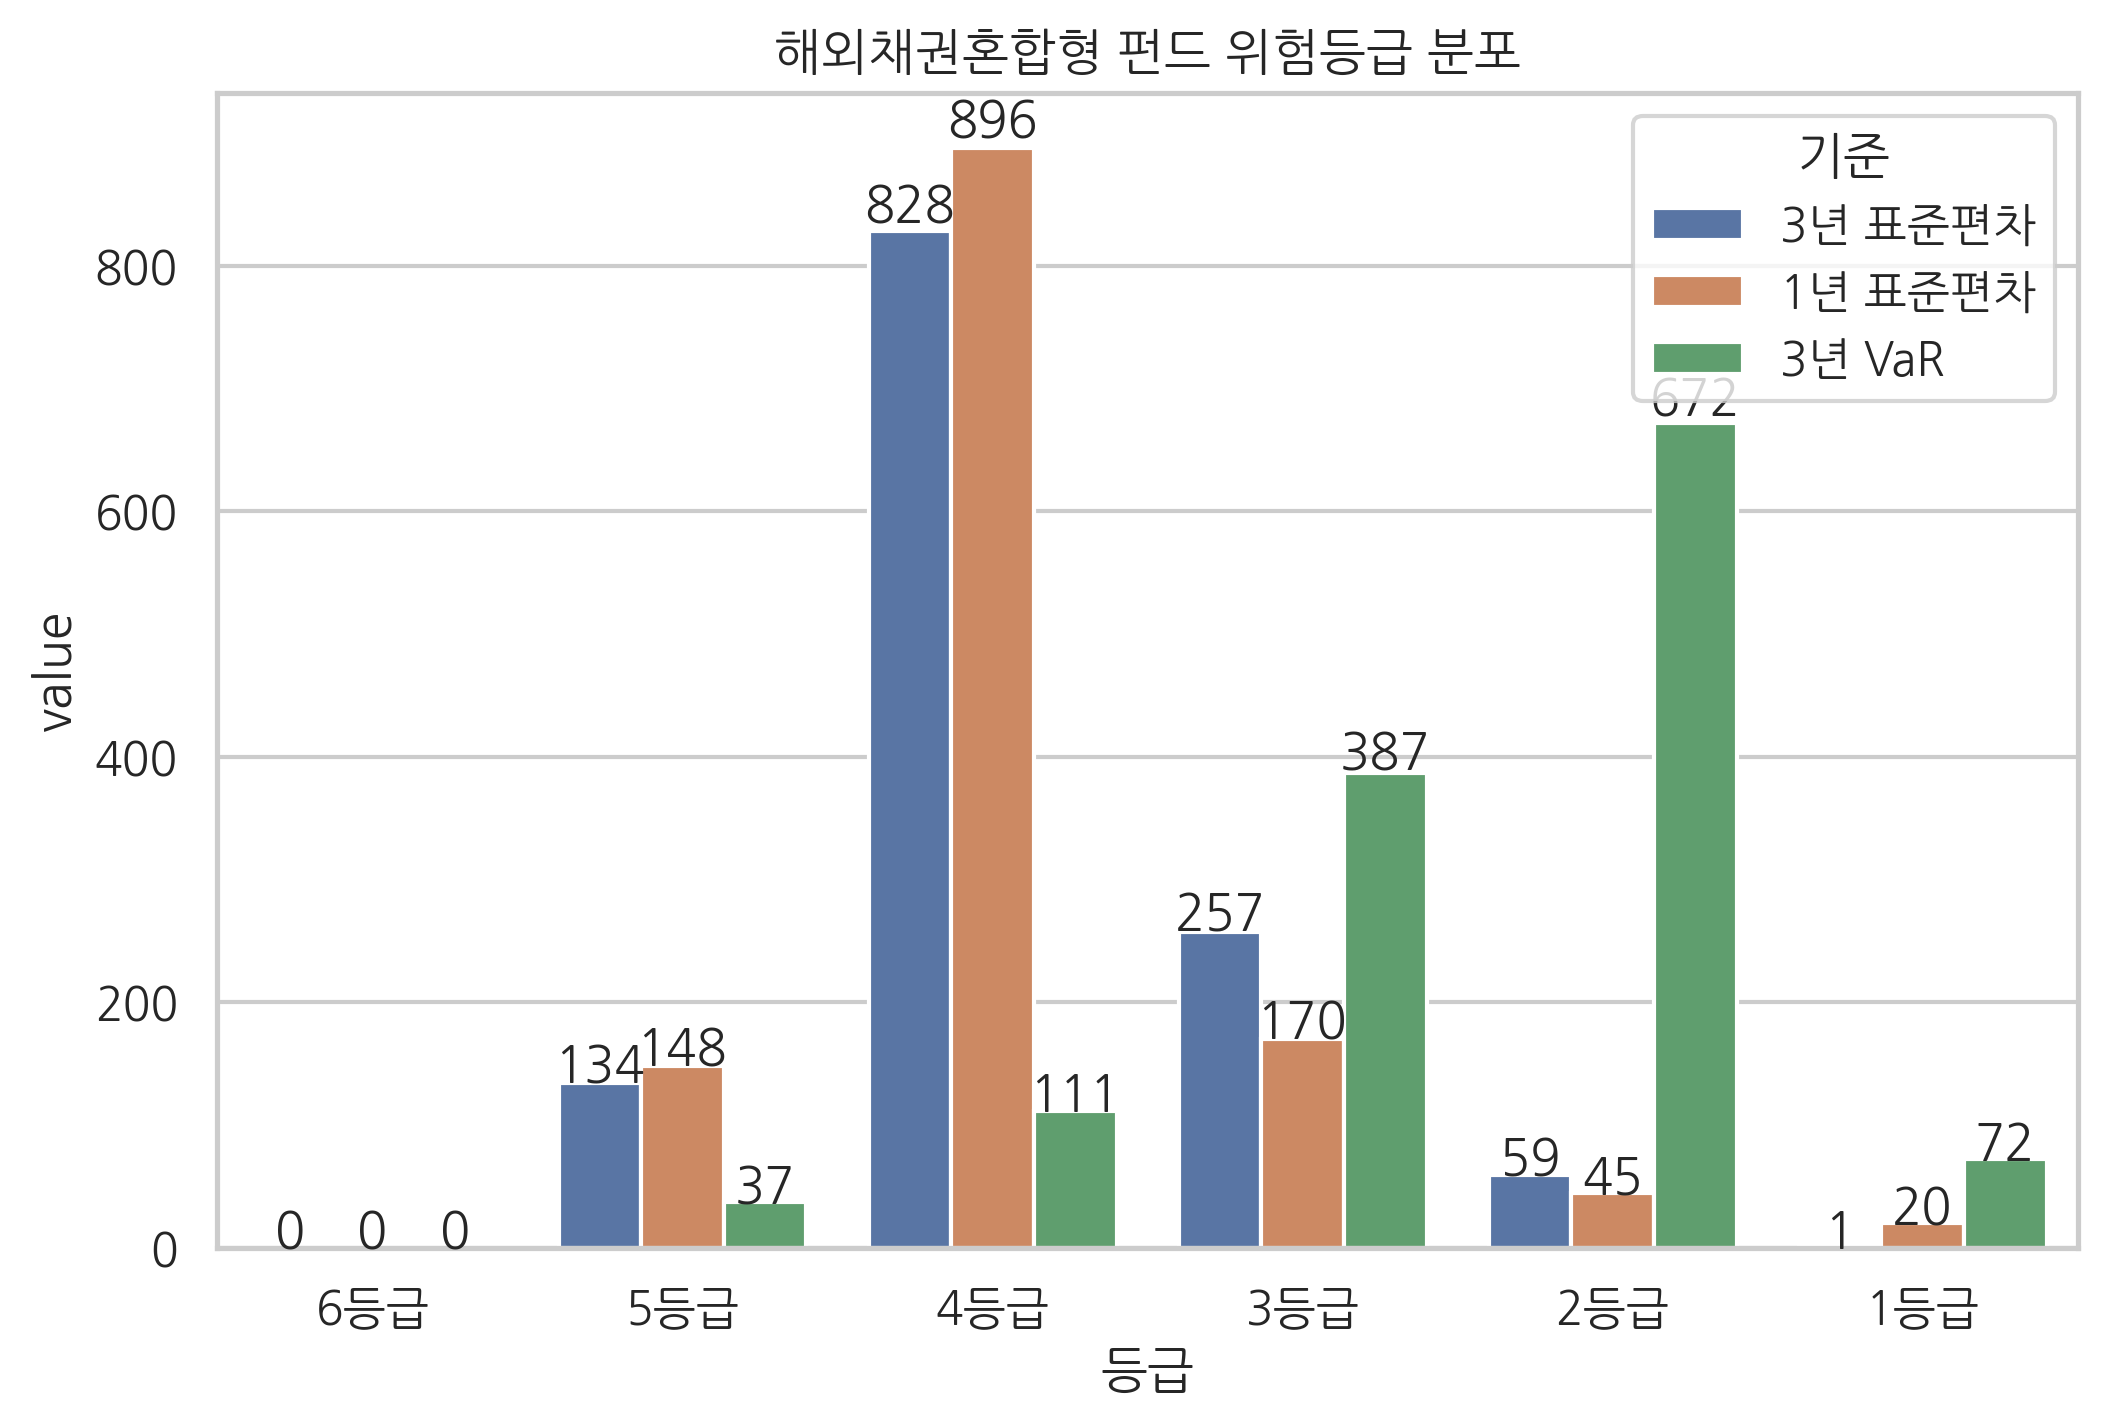

In [10]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:d}'.format(int(p.get_height()))
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:d}'.format(int(p.get_width()))
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)


df_statistics_long = df_statistics\
    .reset_index()\
    .melt(id_vars="index", value_vars=["3년 표준편차", "1년 표준편차", "3년 VaR"], var_name="기준")\
    .rename(columns={"index": "등급"})
axis = sns.barplot(x="등급", y="value", hue="기준", data=df_statistics_long)
axis.set_title(f"{typename} 펀드 위험등급 분포")
show_values(axis)

## 8. Export Statistics

In [11]:
df_statistics.to_csv("STATISTICS_" + fname)